In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import great_circle
pd.options.display.max_columns=30

In [73]:
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

In [259]:
import lightgbm as lgb

In [228]:
coordinates={"NYC":(40.7128, -74.0060),"LA":(34.0522, -118.2437),
             "SF":(37.7749, -122.4194),"DC":(38.9072, -77.0369),
             "Chicago":(41.8781, -87.6298),"Boston":(42.3601, -71.0589)}

In [227]:
train_data=pd.read_csv("train.csv")
test_data=pd.read_csv("test.csv")

#Creating new feature: number of amenities
translator=str.maketrans({"{":"","}":"",'''"''':""})
train_data["num_amenities"]=train_data["amenities"].str.translate(translator).str.split(",").apply(len)
test_data["num_amenities"]=test_data["amenities"].str.translate(translator).str.split(",").apply(len)

#Creating new feature: length of description

train_data["len_description"]=train_data["description"].str.len()
test_data["len_description"]=test_data["description"].str.len()


#Creating new feature: Distance from city centre (Based on Google Coordinates)
train_data["coordinates"]=train_data.apply(lambda x: (x["latitude"],x["longitude"]),axis=1)
test_data["coordinates"]=test_data.apply(lambda x: (x["latitude"],x["longitude"]),axis=1)

train_data["distance"]=train_data.apply(lambda x: great_circle(coordinates[x["city"]],x["coordinates"]).km,axis=1)
test_data["distance"]=test_data.apply(lambda x: great_circle(coordinates[x["city"]],x["coordinates"]).km,axis=1)


features=train_data.columns.drop(["id","log_price","coordinates","amenities","description","first_review","last_review","name","host_since","thumbnail_url","latitude","longitude"])

#Imputing missing values with mode for categorical variables
response_rate_mode=train_data["host_response_rate"].value_counts().index[0]
train_data["host_response_rate"]=train_data["host_response_rate"].fillna(response_rate_mode).str.replace("%","").str.rstrip().map(int)
test_data["host_response_rate"]=test_data["host_response_rate"].fillna(response_rate_mode).str.replace("%","").str.rstrip().map(int)

X_train_data=train_data[features]
X_test_data=test_data[features]
for col in X_train_data.select_dtypes(include=["object"]).columns:
    col_mode=X_train_data[col].value_counts().index[0]
    X_train_data[col].fillna(col_mode,inplace=True)
    X_test_data[col].fillna(col_mode,inplace=True)
    

C:\Users\abhibiswas\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [231]:
#Label Encoding Categorical variables
data=X_train_data.append(X_test_data)
for col in X_train_data.select_dtypes(include=["object"]):
    le=LabelEncoder()
    le.fit(data[col])
    X_train_data[col]=le.transform(X_train_data[col])
    X_test_data[col]=le.transform(X_test_data[col])

C:\Users\abhibiswas\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\abhibiswas\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [232]:
#Imputing missing numerical variables with median
pipeline=Pipeline([("impute",Imputer(strategy='median'))])
X_train_data=pd.DataFrame(pipeline.fit_transform(X_train_data),columns=X_train_data.columns)
X_test_data=pd.DataFrame(pipeline.transform(X_test_data),columns=X_test_data.columns)
Y_train_data=train_data["log_price"]

In [233]:
#Splitting Orgininal training data into train and test
x_train, x_test, y_train, y_test= train_test_split(X_train_data, Y_train_data,random_state=42)

In [298]:
clf=GradientBoostingRegressor(n_estimators=300,max_depth=6)
clf.fit(X_train_data,Y_train_data)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=300,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [299]:
print("Test RMSE:",np.sqrt(mean_squared_error(y_test,clf.predict(x_test))))
print("Train RMSE:",np.sqrt(mean_squared_error(y_train,clf.predict(x_train))))

Test RMSE: 0.341441103322
Train RMSE: 0.341788377393


In [297]:
sorted((zip(clf.feature_importances_,x_train.columns)),key=lambda x: x[0],reverse=True)

[(0.19119883361427503, 'distance'),
 (0.15247282608066898, 'zipcode'),
 (0.088302541116368552, 'neighbourhood'),
 (0.081883051064007381, 'len_description'),
 (0.068163298385171267, 'num_amenities'),
 (0.065196772556161464, 'number_of_reviews'),
 (0.046462045474355694, 'room_type'),
 (0.043866500474624856, 'accommodates'),
 (0.032507512040590242, 'bathrooms'),
 (0.031380888994638541, 'review_scores_rating'),
 (0.03119689164980274, 'property_type'),
 (0.030709482303232758, 'host_response_rate'),
 (0.030072292923454556, 'city'),
 (0.026607254611192451, 'bedrooms'),
 (0.01944317547322277, 'beds'),
 (0.012661344441084953, 'cancellation_policy'),
 (0.01244489916760136, 'cleaning_fee'),
 (0.010854919797528423, 'instant_bookable'),
 (0.010791781970114321, 'bed_type'),
 (0.010701518568778007, 'host_identity_verified'),
 (0.0030821692931256141, 'host_has_profile_pic')]

In [301]:
submission=pd.read_csv("sample_submission.csv")
submission["id"]=test_data["id"]
submission["log_price"]=clf.predict(X_test_data)

In [302]:
submission.to_csv("baseline_submission.csv",index=False)

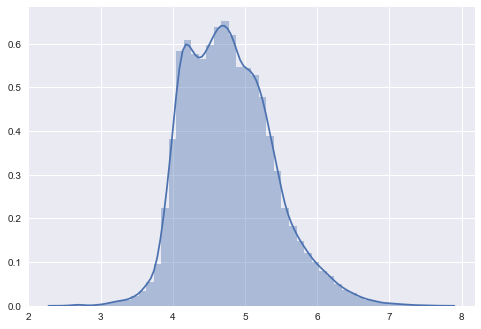

In [300]:
sns.distplot(clf.predict(X_train_data))
plt.show()

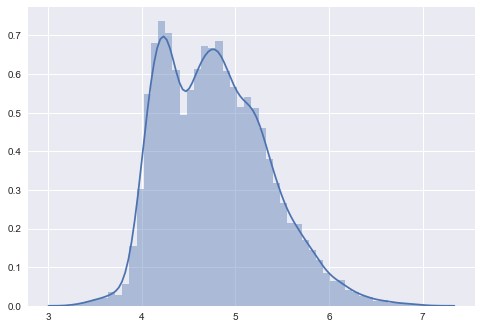

In [240]:
sns.distplot(clf.predict(x_test))
plt.show()

In [256]:
bad_predictions=train_data.iloc[pd.Series(abs(clf.predict(x_test)-y_test)).sort_values(ascending=False).index[:10],:]

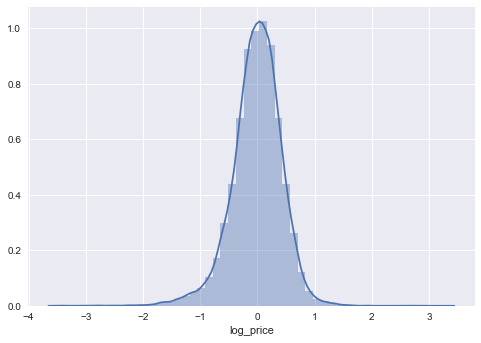

In [89]:
sns.distplot(clf.predict(x_test)-y_test)
plt.show()

In [304]:
# lgb_train = lgb.Dataset(x_train, y_train)
# lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

# # specify your configurations as a dict
# params = {
#     'task': 'train',
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': {'l2', 'auc'},
#     'num_leaves': 10,
#     'learning_rate': 0.1,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0
# }

# print('Start training...')
# # train
# gbm = lgb.train(params,
#                 lgb_train,
#                 num_boost_round=100,
#                 valid_sets=lgb_eval,
#                 early_stopping_rounds=5)

# print('Save model...')
# # save model to file
# gbm.save_model('model.txt')

# print('Start predicting...')
# # predict
# y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)
# # eval
# print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

In [303]:
# gbm = lgb.LGBMRegressor(objective='regression',
#                         num_leaves=127,
#                         learning_rate=0.1,
#                         n_estimators=300)
# gbm.fit(x_train, y_train,
#         eval_set=[(x_test, y_test)],
#         eval_metric='l2',
#         early_stopping_rounds=30)

# print('Start predicting...')
# # predict
# y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration_)
# # eval
# print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

# # feature importances
# print('Feature importances:', list(gbm.feature_importances_))

# # # other scikit-learn modules
# # estimator = lgb.LGBMRegressor(num_leaves=31)

# # param_grid = {
# #     'learning_rate': [0.01, 0.1, 1],
# #     'n_estimators': [20, 40]
# # }

# # gbm = GridSearchCV(estimator, param_grid)

# # gbm.fit(x_train, y_train)

# # print('Best parameters found by grid search are:', gbm.best_params_)